<h1>Introduction</h1>

The dataset contains 75,000 photos, including 15,000 samples of each type of rice.
There are numerous genetic variants of rice, one of the most extensively produced grain crops in the world. These variations are distinguished from one another by some of their characteristics. Often, these include characteristics like texture, shape, and color. These characteristics that set different rice types apart allow for the classification and assessment of seed quality. Five types of rice, commonly farmed in Turkey: Arborio, Basmati, Ipsala, Jasmine, and Karacadag, were used in this study.

The dataset may not consist of all types of rice. There are other external factors that needs to be taken in account like images of rice from other countries where different types of rice is farmed. Due to this, the dataset has some limitations and the model is not completely accurate for all types of rice which might be sourced from different countries.

In this assignment, I have used the rice image dataset which is sourced from Kaggle. Citations can be found in the last part of this assignment.

With the help of this dataset, we will be classifying different varieties of rice. Additionally,  the dataset is a multiclass, single-label classification which means that the last-layer activation would be completed using softmax and the loss function will be calculated with the help of categorical_crossentropy. 

<h2>Importing libraries</h2>

In [98]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import glob as gb
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from tensorflow.keras import models,layers
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, precision_score
from tensorflow.python.ops.numpy_ops import np_utils
import os
from keras.utils import to_categorical

<h2>Loading Data</h2>

In [99]:
data = './Rice_Image_Dataset/'

In [100]:
for folder in  os.listdir(data): 
    files = gb.glob(pathname= str( data + folder + '/*.jpg'))
    print(f'For data , found {len(files)} in folder {folder}')

For data , found 15000 in folder Arborio
For data , found 15000 in folder Basmati
For data , found 15000 in folder Ipsala
For data , found 15000 in folder Jasmine
For data , found 15000 in folder Karacadag
For data , found 0 in folder Rice_Citation_Request.txt


In [101]:
code = {'Karacadag':0 ,'Basmati':1 ,'Jasmine':2,'Arborio':3, 'Ipsala':4}
def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x  

Restructuring data as it is too high in volume.

In [102]:
s = 100
X_Images = []
y_Types = []
for folder in  os.listdir(data) : 
    files = gb.glob(pathname= str( data + folder + '/*.jpg'))
    for file in files[:500]: 
        image = cv2.imread(file)
        image_array = cv2.resize(image , (s,s))
        X_Images.append(list(image_array))
        y_Types.append(code[folder])

In [103]:
print(f'we have {len(X_Images)} items in X_Images')
print(f'we have {len(y_Types)} items in Y_Types')

we have 2500 items in X_Images
we have 2500 items in Y_Types


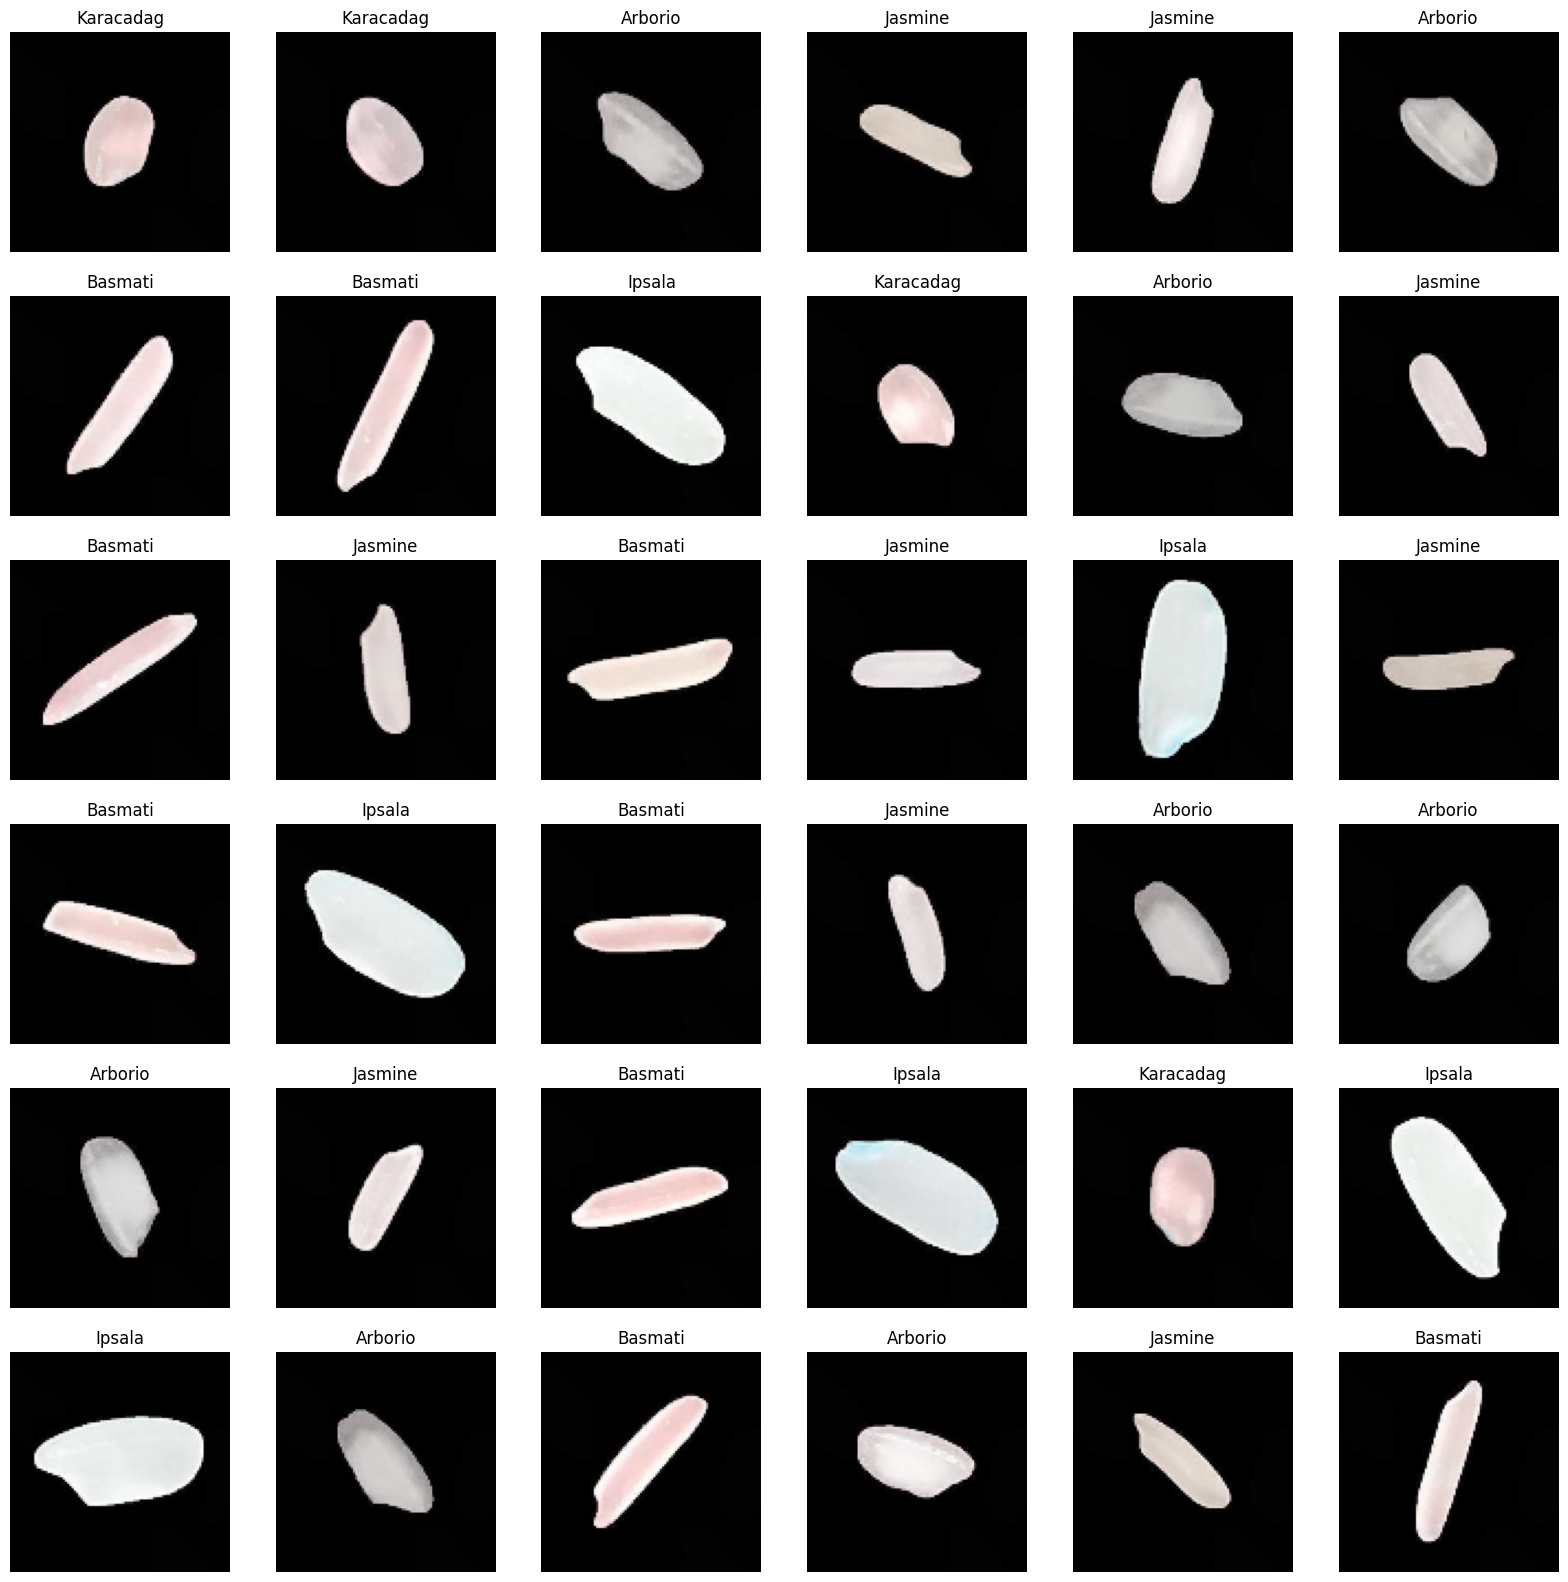

In [104]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(X_Images),36))) : 
    plt.subplot(6,6,n+1)
    plt.imshow(X_Images[i])   
    plt.axis('off')
    plt.title(getcode(y_Types[i]))

<h3>Splitting data</h3>

In this section, the data is splitted with the help of the train_test_split function.

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X_Images, y_Types, train_size=0.8, shuffle=True, random_state=100)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, shuffle=True, random_state=100)

<h2>Baseline</h2>

In this section, we will be finding out the baseline accuracy of the data.

In [106]:
totals_train=np.zeros(10)
totals_test=np.zeros(10)
total_y_train=np.concatenate([y_train,y_val])
for i in range(len(total_y_train)):
    totals_train[total_y_train[i]]+=1
    
for i in range(len(y_test)):
    totals_test[y_test[i]]+=1
indx=np.argmax(totals_train)
hits=totals_test[indx]
hit_rate=hits/np.sum(y_test)
print('Most frequent label:',indx)
print('Percentage of accuracy using probability model:',(hit_rate*100))        

Most frequent label: 0
Percentage of accuracy using probability model: 6.728971962616822


So the baseline accuracy is 6.73%.

<h2>Preparing the data</h2>

In this part we will be rescaling the data and casting it to float. We will also be categorizing the data with the help of to_categorical() function in order to carry out one-hot encoding.

In [107]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_val=np.array(X_val)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val=np.array(y_val)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(2000, 100, 100, 3)
(250, 100, 100, 3)
(250, 100, 100, 3)


In [108]:
X_train=X_train.astype('float32')/255
X_test=X_test.astype('float32')/255
X_val=X_val.astype('float32')/255

y_train=to_categorical(y_train)
y_test=to_categorical(y_test)
y_val = to_categorical(y_val)

<h2>Plotting functions</h2>

For this section, I have created the functions which would plot the accuracy and loss. We will be using these functions in the process of building the model. These functions will make it easier to analyse the performance of the model.

<h3>Plotting loss function</h3>

In [109]:
def plot_loss(loss,val_loss):
    '''plotting training loss and validation loss'''
    plt.clf()
    epochs=range(1,len(loss)+1)
    plt.plot(epochs,loss,'bo',label="Loss")
    plt.plot(epochs,val_loss,'b',label="validation loss")
    plt.title("Training Loss & Validation Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

<h3>Plotting accuracy function</h3>

In [110]:
def plot_accuracy(acc,val_acc):
    '''plotting training accuracy and validation accuracy'''
    plt.clf()
    epochs=range(1,len(acc)+1)
    plt.plot(epochs,acc,'bo',label="Accuracy")
    plt.plot(epochs,val_acc,'b',label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel('Epochs')
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

<h2>Developing the model</h2>

For the model, I have chosen the Adam optimizer as it has better performance than every other optimization technique, takes less time to compute, and need lesser tuning parameters. The last layer activation is softmax and the loss function is categorical_crossentropy. 

In [111]:
Keras_Model = keras.models.Sequential([
        Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(s,s,3)),
        Flatten() ,
        Dense(5,activation='softmax') ,    
        ])

In [112]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
Keras_Model.compile(optimizer =opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [113]:
epochs = 10
ThisModel = Keras_Model.fit(X_train, y_train, epochs=epochs,batch_size=32,verbose=1, 
                       validation_data=(X_val,y_val))

Epoch 1/10
63/63 [==============================] - 9s 127ms/step - loss: 0.9452 - accuracy: 0.6780 - val_loss: 0.5284 - val_accuracy: 0.8840
Epoch 2/10
63/63 [==============================] - 8s 120ms/step - loss: 0.3715 - accuracy: 0.9600 - val_loss: 0.2469 - val_accuracy: 0.9640
Epoch 3/10
63/63 [==============================] - 8s 121ms/step - loss: 0.1952 - accuracy: 0.9725 - val_loss: 0.1479 - val_accuracy: 0.9760
Epoch 4/10
63/63 [==============================] - 8s 120ms/step - loss: 0.1348 - accuracy: 0.9765 - val_loss: 0.1088 - val_accuracy: 0.9720
Epoch 5/10
63/63 [==============================] - 8s 119ms/step - loss: 0.0989 - accuracy: 0.9795 - val_loss: 0.0972 - val_accuracy: 0.9880
Epoch 6/10
63/63 [==============================] - 8s 119ms/step - loss: 0.0806 - accuracy: 0.9835 - val_loss: 0.0826 - val_accuracy: 0.9920
Epoch 7/10
63/63 [==============================] - 8s 120ms/step - loss: 0.0633 - accuracy: 0.9895 - val_loss: 0.0659 - val_accuracy: 0.9760
Epoch 

In [114]:
print('Model Details are : ')
print(KerasModel.summary())

Model Details are : 
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 flatten_3 (Flatten)         (None, 307328)            0         
                                                                 
 dense_13 (Dense)            (None, 5)                 1536645   
                                                                 
Total params: 1,537,541
Trainable params: 1,537,541
Non-trainable params: 0
_________________________________________________________________
None


Plotting loss

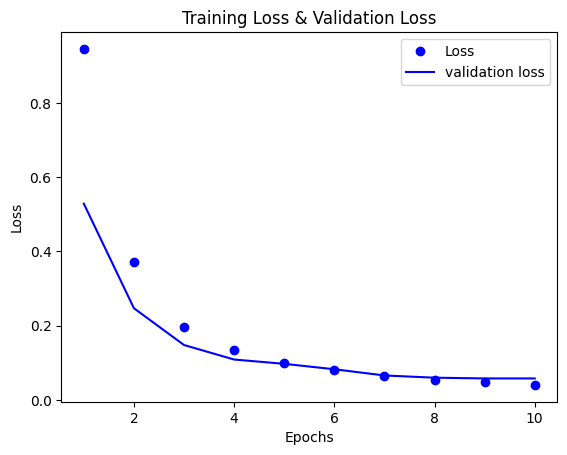

In [115]:
plot_loss(ThisModel.history['loss'],ThisModel.history['val_loss'])

Plotting accuracy

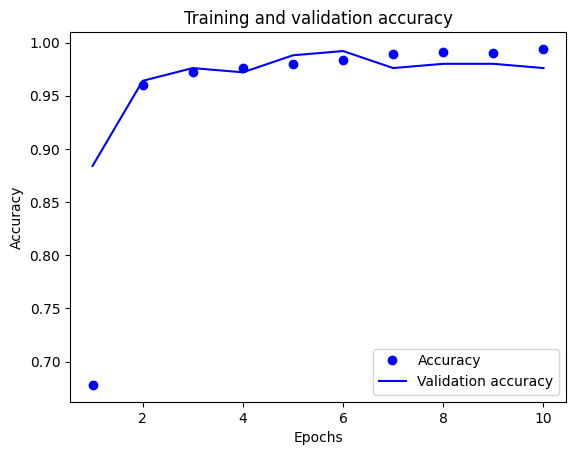

In [116]:
plot_accuracy(ThisModel.history['accuracy'],ThisModel.history['val_accuracy'])

In [117]:
loss_test,test_accuracy=KerasModel.evaluate(X_val,y_val)

8/8 [==============================] - 0s 38ms/step - loss: 0.0579 - accuracy: 0.9760


As you can see, the accuracy is better than the baseline accuracy.

<h2>Developing a model that overfits</h2>

For this section, we will be creating a model that overfits in order to get an idea of building a model that comes in between overfitting and underfitting.

In [118]:
KerasOverfitModel = keras.models.Sequential([
        Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(s,s,3)),
        Flatten() ,
        Dense(512,activation='relu') ,    
        Dense(512,activation='relu') ,    
        Dense(256,activation='relu') ,
        Dense(256,activation='relu') ,
        Dense(128,activation='relu') ,
        Dense(5,activation='softmax') ,    
        ])

In [119]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
KerasOverfitModel.compile(optimizer =opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [120]:
epochs = 40
ThisModel = KerasOverfitModel.fit(X_train, y_train, epochs=epochs,batch_size=32,verbose=1, 
                       validation_data=(X_val,y_val))

Epoch 1/40
63/63 [==============================] - 160s 2s/step - loss: 0.5768 - accuracy: 0.8325 - val_loss: 0.1170 - val_accuracy: 0.9640
Epoch 2/40
63/63 [==============================] - 149s 2s/step - loss: 0.0702 - accuracy: 0.9840 - val_loss: 0.0459 - val_accuracy: 0.9840
Epoch 3/40
63/63 [==============================] - 151s 2s/step - loss: 0.0419 - accuracy: 0.9885 - val_loss: 0.0489 - val_accuracy: 0.9840
Epoch 4/40
63/63 [==============================] - 146s 2s/step - loss: 0.0220 - accuracy: 0.9940 - val_loss: 0.0373 - val_accuracy: 0.9880
Epoch 5/40
63/63 [==============================] - 140s 2s/step - loss: 0.0156 - accuracy: 0.9965 - val_loss: 0.0176 - val_accuracy: 0.9960
Epoch 6/40
63/63 [==============================] - 141s 2s/step - loss: 0.0161 - accuracy: 0.9930 - val_loss: 0.0224 - val_accuracy: 0.9920
Epoch 7/40
63/63 [==============================] - 136s 2s/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0312 - val_accuracy: 0.9920
Epoch 8/40
63

In [121]:
print('Model Details are : ')
print(KerasOverfitModel.summary())

Model Details are : 
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 flatten_4 (Flatten)         (None, 307328)            0         
                                                                 
 dense_14 (Dense)            (None, 512)               157352448 
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 dense_16 (Dense)            (None, 256)               131328    
                                                                 
 dense_17 (Dense)            (None, 256)               65792     
                                                                 
 dense_18 (Dense)            (Non

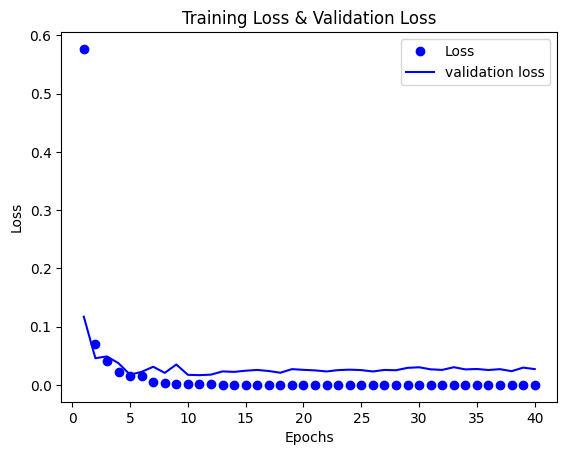

In [122]:
plot_loss(ThisModel.history['loss'],ThisModel.history['val_loss'])

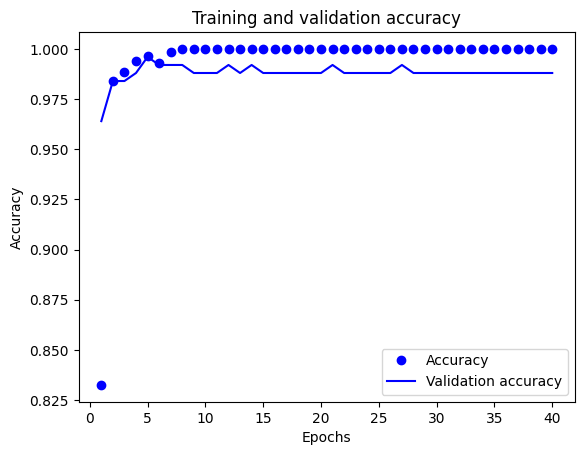

In [123]:
plot_accuracy(ThisModel.history['accuracy'],ThisModel.history['val_accuracy'])

In [124]:
loss_test,test_accuracy=KerasOverfitModel.evaluate(X_val,y_val)

8/8 [==============================] - 1s 124ms/step - loss: 0.0272 - accuracy: 0.9880


<h2>Regularizing the model</h2>

There are different ways to regularise the model. For this model, I will be adding dropout and adding more layers. 

In [128]:
KerasDropOutModel = keras.models.Sequential([
        Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(s,s,3)),
        Flatten() ,
        Dense(512,activation='relu') ,
        Dropout(0.7),
        Dense(512,activation='relu') ,    
        Dense(256,activation='relu') ,
        Dense(256,activation='relu') ,
        Dense(128,activation='relu') ,
        Dense(5,activation='softmax') ,    
        ])

In [129]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
KerasDropOutModel.compile(optimizer =opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [130]:
epochs = 20
ThisModel = KerasDropOutModel.fit(X_train, y_train, epochs=epochs,batch_size=32,verbose=1, 
                       validation_data=(X_val,y_val))

Epoch 1/20
63/63 [==============================] - 419s 6s/step - loss: 1.2867 - accuracy: 0.4140 - val_loss: 0.8104 - val_accuracy: 0.6080
Epoch 2/20
63/63 [==============================] - 151s 2s/step - loss: 0.7654 - accuracy: 0.6930 - val_loss: 0.4585 - val_accuracy: 0.8320
Epoch 3/20
63/63 [==============================] - 149s 2s/step - loss: 0.4867 - accuracy: 0.8145 - val_loss: 0.1954 - val_accuracy: 0.9480
Epoch 4/20
63/63 [==============================] - 139s 2s/step - loss: 0.3161 - accuracy: 0.8810 - val_loss: 0.1315 - val_accuracy: 0.9440
Epoch 5/20
63/63 [==============================] - 140s 2s/step - loss: 0.2293 - accuracy: 0.9205 - val_loss: 0.1008 - val_accuracy: 0.9600
Epoch 6/20
63/63 [==============================] - 141s 2s/step - loss: 0.1752 - accuracy: 0.9375 - val_loss: 0.1080 - val_accuracy: 0.9440
Epoch 7/20
63/63 [==============================] - 139s 2s/step - loss: 0.1663 - accuracy: 0.9435 - val_loss: 0.1348 - val_accuracy: 0.9320
Epoch 8/20
63

In [131]:
print('Model Details are : ')
print(KerasDropOutModel.summary())

Model Details are : 
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 flatten_6 (Flatten)         (None, 307328)            0         
                                                                 
 dense_26 (Dense)            (None, 512)               157352448 
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_27 (Dense)            (None, 512)               262656    
                                                                 
 dense_28 (Dense)            (None, 256)               131328    
                                                                 
 dense_29 (Dense)            (Non

Plotting accuracy

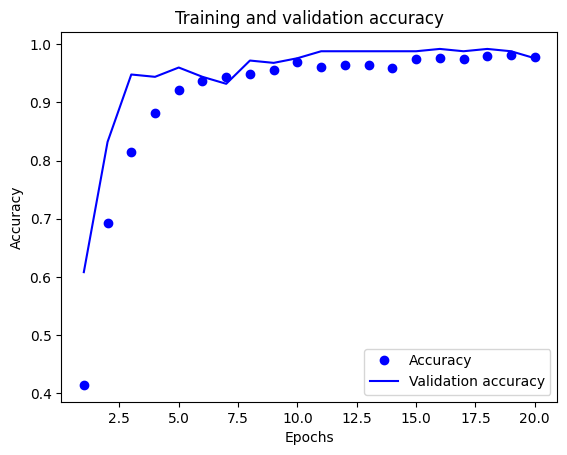

In [132]:
plot_accuracy(ThisModel.history['accuracy'],ThisModel.history['val_accuracy'])

Plotting loss


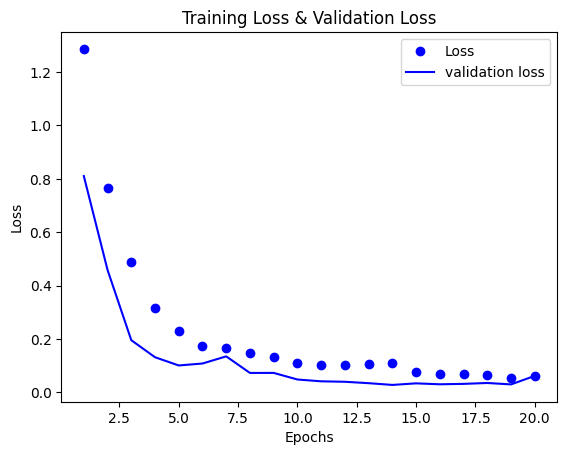

In [133]:
plot_loss(ThisModel.history['loss'],ThisModel.history['val_loss'])

In [134]:
loss_test,test_accuracy=KerasDropOutModel.evaluate(X_val,y_val)

8/8 [==============================] - 1s 133ms/step - loss: 0.0617 - accuracy: 0.9760


<h2>Adding more layers</h2>

In [135]:
KerasLayersModel = keras.models.Sequential([
        Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(s,s,3)),
        Conv2D(32,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64,kernel_size=(5,5),activation='relu'),    
        Conv2D(64,kernel_size=(5,5),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128,kernel_size=(5,5),activation='relu'),
        Conv2D(128,kernel_size=(5,5),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(256,kernel_size=(3,3),activation='relu'),
        Conv2D(256,kernel_size=(3,3),activation='relu'),
        Flatten() ,
        Dense(512,activation='relu') ,    
        Dense(512,activation='relu') ,    
        Dense(256,activation='relu') ,
        Dense(256,activation='relu') ,
        Dense(128,activation='relu') ,
        Dense(5,activation='softmax') ,    
        ])

In [136]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
KerasLayersModel.compile(optimizer =opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [137]:
epochs = 20
ThisModel = KerasLayersModel.fit(X_train, y_train, epochs=epochs,batch_size=32,verbose=1, 
                       validation_data=(X_val,y_val))

Epoch 1/20
63/63 [==============================] - 86s 1s/step - loss: 1.2503 - accuracy: 0.5240 - val_loss: 0.5249 - val_accuracy: 0.7880
Epoch 2/20
63/63 [==============================] - 74s 1s/step - loss: 0.3735 - accuracy: 0.8450 - val_loss: 0.2212 - val_accuracy: 0.9480
Epoch 3/20
63/63 [==============================] - 75s 1s/step - loss: 0.2014 - accuracy: 0.9170 - val_loss: 0.2336 - val_accuracy: 0.9320
Epoch 4/20
63/63 [==============================] - 75s 1s/step - loss: 0.1394 - accuracy: 0.9455 - val_loss: 0.0943 - val_accuracy: 0.9720
Epoch 5/20
63/63 [==============================] - 74s 1s/step - loss: 0.1097 - accuracy: 0.9595 - val_loss: 0.0921 - val_accuracy: 0.9680
Epoch 6/20
63/63 [==============================] - 74s 1s/step - loss: 0.1461 - accuracy: 0.9440 - val_loss: 0.1291 - val_accuracy: 0.9760
Epoch 7/20
63/63 [==============================] - 76s 1s/step - loss: 0.1217 - accuracy: 0.9585 - val_loss: 0.0571 - val_accuracy: 0.9800
Epoch 8/20
63/63 [==

In [138]:
print('Model Details are : ')
print(KerasModel.summary())

Model Details are : 
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 flatten_3 (Flatten)         (None, 307328)            0         
                                                                 
 dense_13 (Dense)            (None, 5)                 1536645   
                                                                 
Total params: 1,537,541
Trainable params: 1,537,541
Non-trainable params: 0
_________________________________________________________________
None


Plotting loss

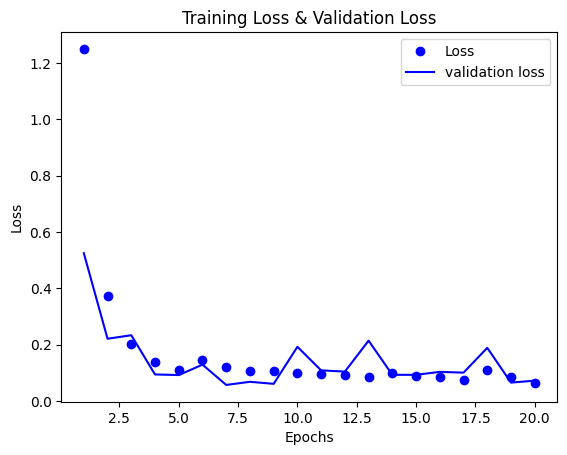

In [139]:
plot_loss(ThisModel.history['loss'],ThisModel.history['val_loss'])

Plotting accuracy

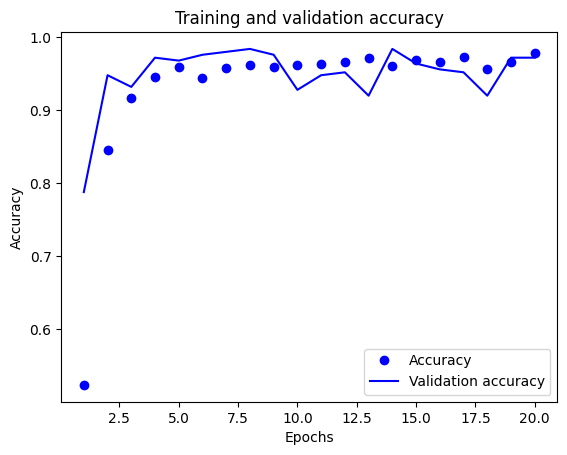

In [140]:
plot_accuracy(ThisModel.history['accuracy'],ThisModel.history['val_accuracy'])

In [141]:
loss_test,test_accuracy=KerasLayersModel.evaluate(X_val,y_val)

8/8 [==============================] - 3s 387ms/step - loss: 0.0722 - accuracy: 0.9720


<h2>Combining last two methods</h2>

For this part, I will be combining the dropout method and adding layers method which I had carried out individually in the last two sections.

In [142]:
KerasFinalModel = keras.models.Sequential([
        Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(s,s,3)),
        Conv2D(32,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64,kernel_size=(5,5),activation='relu'),    
        Conv2D(64,kernel_size=(5,5),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128,kernel_size=(5,5),activation='relu'),
        Conv2D(128,kernel_size=(5,5),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(256,kernel_size=(3,3),activation='relu'),
        Conv2D(256,kernel_size=(3,3),activation='relu'),
        Flatten() ,
        Dense(512,activation='relu') , 
        Dropout(0.7),
        Dense(512,activation='relu') ,    
        Dense(256,activation='relu') ,
        Dense(256,activation='relu') ,
        Dense(128,activation='relu') ,
        Dense(5,activation='softmax') ,    
        ])

In [143]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
KerasFinalModel.compile(optimizer =opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [144]:
epochs = 20
ThisModel = KerasFinalModel.fit(X_train, y_train, epochs=epochs,batch_size=32,verbose=1, 
                       validation_data=(X_val,y_val))

Epoch 1/20
63/63 [==============================] - 109s 2s/step - loss: 1.5692 - accuracy: 0.2790 - val_loss: 1.2893 - val_accuracy: 0.4880
Epoch 2/20
63/63 [==============================] - 82s 1s/step - loss: 1.0392 - accuracy: 0.5155 - val_loss: 0.8133 - val_accuracy: 0.6080
Epoch 3/20
63/63 [==============================] - 86s 1s/step - loss: 0.7281 - accuracy: 0.6595 - val_loss: 0.5884 - val_accuracy: 0.6720
Epoch 4/20
63/63 [==============================] - 90s 1s/step - loss: 0.5636 - accuracy: 0.7240 - val_loss: 0.3952 - val_accuracy: 0.8760
Epoch 5/20
63/63 [==============================] - 88s 1s/step - loss: 0.4306 - accuracy: 0.8085 - val_loss: 0.3064 - val_accuracy: 0.8600
Epoch 6/20
63/63 [==============================] - 81s 1s/step - loss: 0.3077 - accuracy: 0.8725 - val_loss: 0.1808 - val_accuracy: 0.9320
Epoch 7/20
63/63 [==============================] - 80s 1s/step - loss: 0.3073 - accuracy: 0.8755 - val_loss: 0.1931 - val_accuracy: 0.9080
Epoch 8/20
63/63 [=

In [145]:
print('Model Details are : ')
print(KerasFinalModel.summary()) 

Model Details are : 
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 98, 98, 32)        896       
                                                                 
 conv2d_30 (Conv2D)          (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_31 (Conv2D)          (None, 44, 44, 64)        51264     
                                                                 
 conv2d_32 (Conv2D)          (None, 40, 40, 64)        102464    
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 20, 20, 64)       0         
 g2D)                            

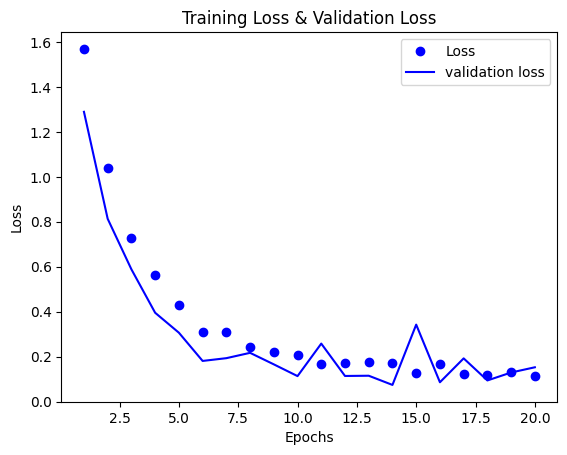

In [146]:
plot_loss(ThisModel.history['loss'],ThisModel.history['val_loss'])

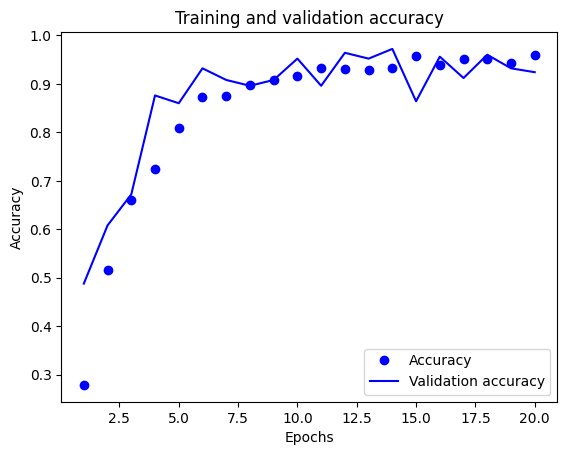

In [147]:
plot_accuracy(ThisModel.history['accuracy'],ThisModel.history['val_accuracy'])

<h1>Final model</h1>

In [148]:
FinalModel = keras.models.Sequential([
        Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(s,s,3)),
        Conv2D(32,kernel_size=(3,3),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(64,kernel_size=(5,5),activation='relu'),    
        Conv2D(64,kernel_size=(5,5),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128,kernel_size=(5,5),activation='relu'),
        Conv2D(128,kernel_size=(5,5),activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(256,kernel_size=(3,3),activation='relu'),
        Conv2D(256,kernel_size=(3,3),activation='relu'),
        Flatten() ,
        Dense(512,activation='relu') , 
        Dropout(0.7),
        Dense(512,activation='relu') ,    
        Dense(256,activation='relu') ,
        Dense(256,activation='relu') ,
        Dense(128,activation='relu') ,
        Dense(5,activation='softmax') ,    
        ])

In [149]:
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)
FinalModel.compile(optimizer =opt,loss='categorical_crossentropy',metrics=['accuracy'])

In [150]:
epochs = 12
Final_Model = FinalModel.fit(np.concatenate([X_train,X_val]), np.concatenate([y_train,y_val]), epochs=epochs,batch_size=32,verbose=1, 
                       validation_data=(X_test,y_test))

Epoch 1/12
71/71 [==============================] - 89s 1s/step - loss: 1.5696 - accuracy: 0.2333 - val_loss: 1.3464 - val_accuracy: 0.4600
Epoch 2/12
71/71 [==============================] - 84s 1s/step - loss: 0.9610 - accuracy: 0.5338 - val_loss: 0.6636 - val_accuracy: 0.6360
Epoch 3/12
71/71 [==============================] - 84s 1s/step - loss: 0.5647 - accuracy: 0.7213 - val_loss: 0.4621 - val_accuracy: 0.7120
Epoch 4/12
71/71 [==============================] - 85s 1s/step - loss: 0.4001 - accuracy: 0.8222 - val_loss: 0.3167 - val_accuracy: 0.8400
Epoch 5/12
71/71 [==============================] - 83s 1s/step - loss: 0.2715 - accuracy: 0.8911 - val_loss: 0.2524 - val_accuracy: 0.8800
Epoch 6/12
71/71 [==============================] - 84s 1s/step - loss: 0.2482 - accuracy: 0.9004 - val_loss: 0.2736 - val_accuracy: 0.9080
Epoch 7/12
71/71 [==============================] - 85s 1s/step - loss: 0.2108 - accuracy: 0.9080 - val_loss: 0.2123 - val_accuracy: 0.8960
Epoch 8/12
71/71 [==

<h3>Evaluating</h3>

In [161]:
test_loss,test_acc=FinalModel.evaluate(X_test,y_test)
print('Test Loss(in percentage) is {:.0%}'.format(test_loss))
print('Test Accuracy(in percentage): {:.0%} (baseline accuracy is 6.73%)'.format(test_acc))

8/8 [==============================] - 3s 323ms/step - loss: 0.1941 - accuracy: 0.9120
Test Loss(in percentage) is 19%
Test Accuracy(in percentage): 91% (baseline accuracy is 6.73%)


In [162]:
y_pred  =np.argmax(FinalModel.predict(X_test),axis=1)
Y_test = np.argmax(y_test,axis=1)
print('Prediction Shape is {}'.format(y_pred.shape))

8/8 [==============================] - 3s 305ms/step
Prediction Shape is (250,)


Confusion Matrix is
 [[36  0  0  0  0]
 [ 0 52  1  0  0]
 [ 1  0 50  0  0]
 [18  0  2 40  0]
 [ 0  0  0  0 50]]


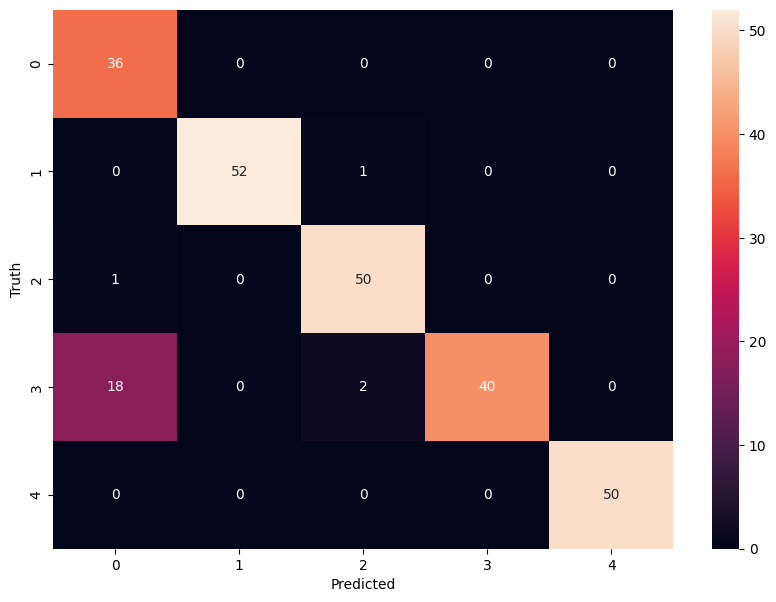

In [163]:
CM = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(CM,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

print('Confusion Matrix is\n', CM)

In [165]:
print(classification_report(Y_test, y_pred))
print(accuracy_score(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        36
           1       1.00      0.98      0.99        53
           2       0.94      0.98      0.96        51
           3       1.00      0.67      0.80        60
           4       1.00      1.00      1.00        50

    accuracy                           0.91       250
   macro avg       0.92      0.93      0.91       250
weighted avg       0.94      0.91      0.91       250

0.912


As you can see, the model is performing better than the baseline.

<h1>Conclusion</h1>

To conclude, I have successfully built a model which is trained on the rice image dataset.I carried out the model building process with the help of hold out validation which has given a good accuracy rate. 

<h2>References</h2>

Dataset source:

https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset

<h2>Citation request</h2>

Rice Image Dataset
DATASET: https://www.muratkoklu.com/datasets/

Citation Request: See the articles for more detailed information on the data.

Koklu, M., Cinar, I., & Taspinar, Y. S. (2021). Classification of rice varieties with deep learning methods. Computers and Electronics in Agriculture, 187, 106285. https://doi.org/10.1016/j.compag.2021.106285

Cinar, I., & Koklu, M. (2021). Determination of Effective and Specific Physical Features of Rice Varieties by Computer Vision In Exterior Quality Inspection. Selcuk Journal of Agriculture and Food Sciences, 35(3), 229-243. https://doi.org/10.15316/SJAFS.2021.252

Cinar, I., & Koklu, M. (2022). Identification of Rice Varieties Using Machine Learning Algorithms. Journal of Agricultural Sciences https://doi.org/10.15832/ankutbd.862482

Cinar, I., & Koklu, M. (2019). Classification of Rice Varieties Using Artificial Intelligence Methods. International Journal of Intelligent Systems and Applications in Engineering, 7(3), 188-194. https://doi.org/10.18201/ijisae.2019355381

DATASET: https://www.muratkoklu.com/datasets/